In [1]:
# Matlab plots inline
%matplotlib inline

# Auto reload external files after changes
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import cv2
import matplotlib.pyplot as plt

from image_set import ImgSet
from image_process import ZernikeProc
from image_process import ResizeProc
import zernike as zn

Loading SHTOOLS documentation


In [3]:
ant_set = ImgSet(name='trees_hr', data_folder='../data/world_images', force_cache=True)
ant_set.M.shape

Loading cache file: ../data/world_images/trees_hr.npz


(37440, 40401)

In [48]:
def resized_image_matrix(im_set, scale=0.5):
    h_scaled = int(im_set.h * scale)
    w_scaled = int(im_set.w * scale)
    print h_scaled
    print w_scaled
    M_resized = np.empty([h_scaled * w_scaled, len(im_set)], dtype='uint8')
    print M_resized.shape
    for i, image in enumerate(im_set):
        M_resized[:,i] = sp.misc.imresize(im_set[i], scale).reshape(-1)
    return M_resized

In [55]:
def manual_distance(I, M):
    """Compare an image to all other images using IDF"""
    
    I_tiled = np.tile(I, (M.shape[1],1)).T
    abs_diff = np.abs(M - I_tiled)
    
    return np.sum(abs_diff, axis=0)

104
360
(37440, 40401)


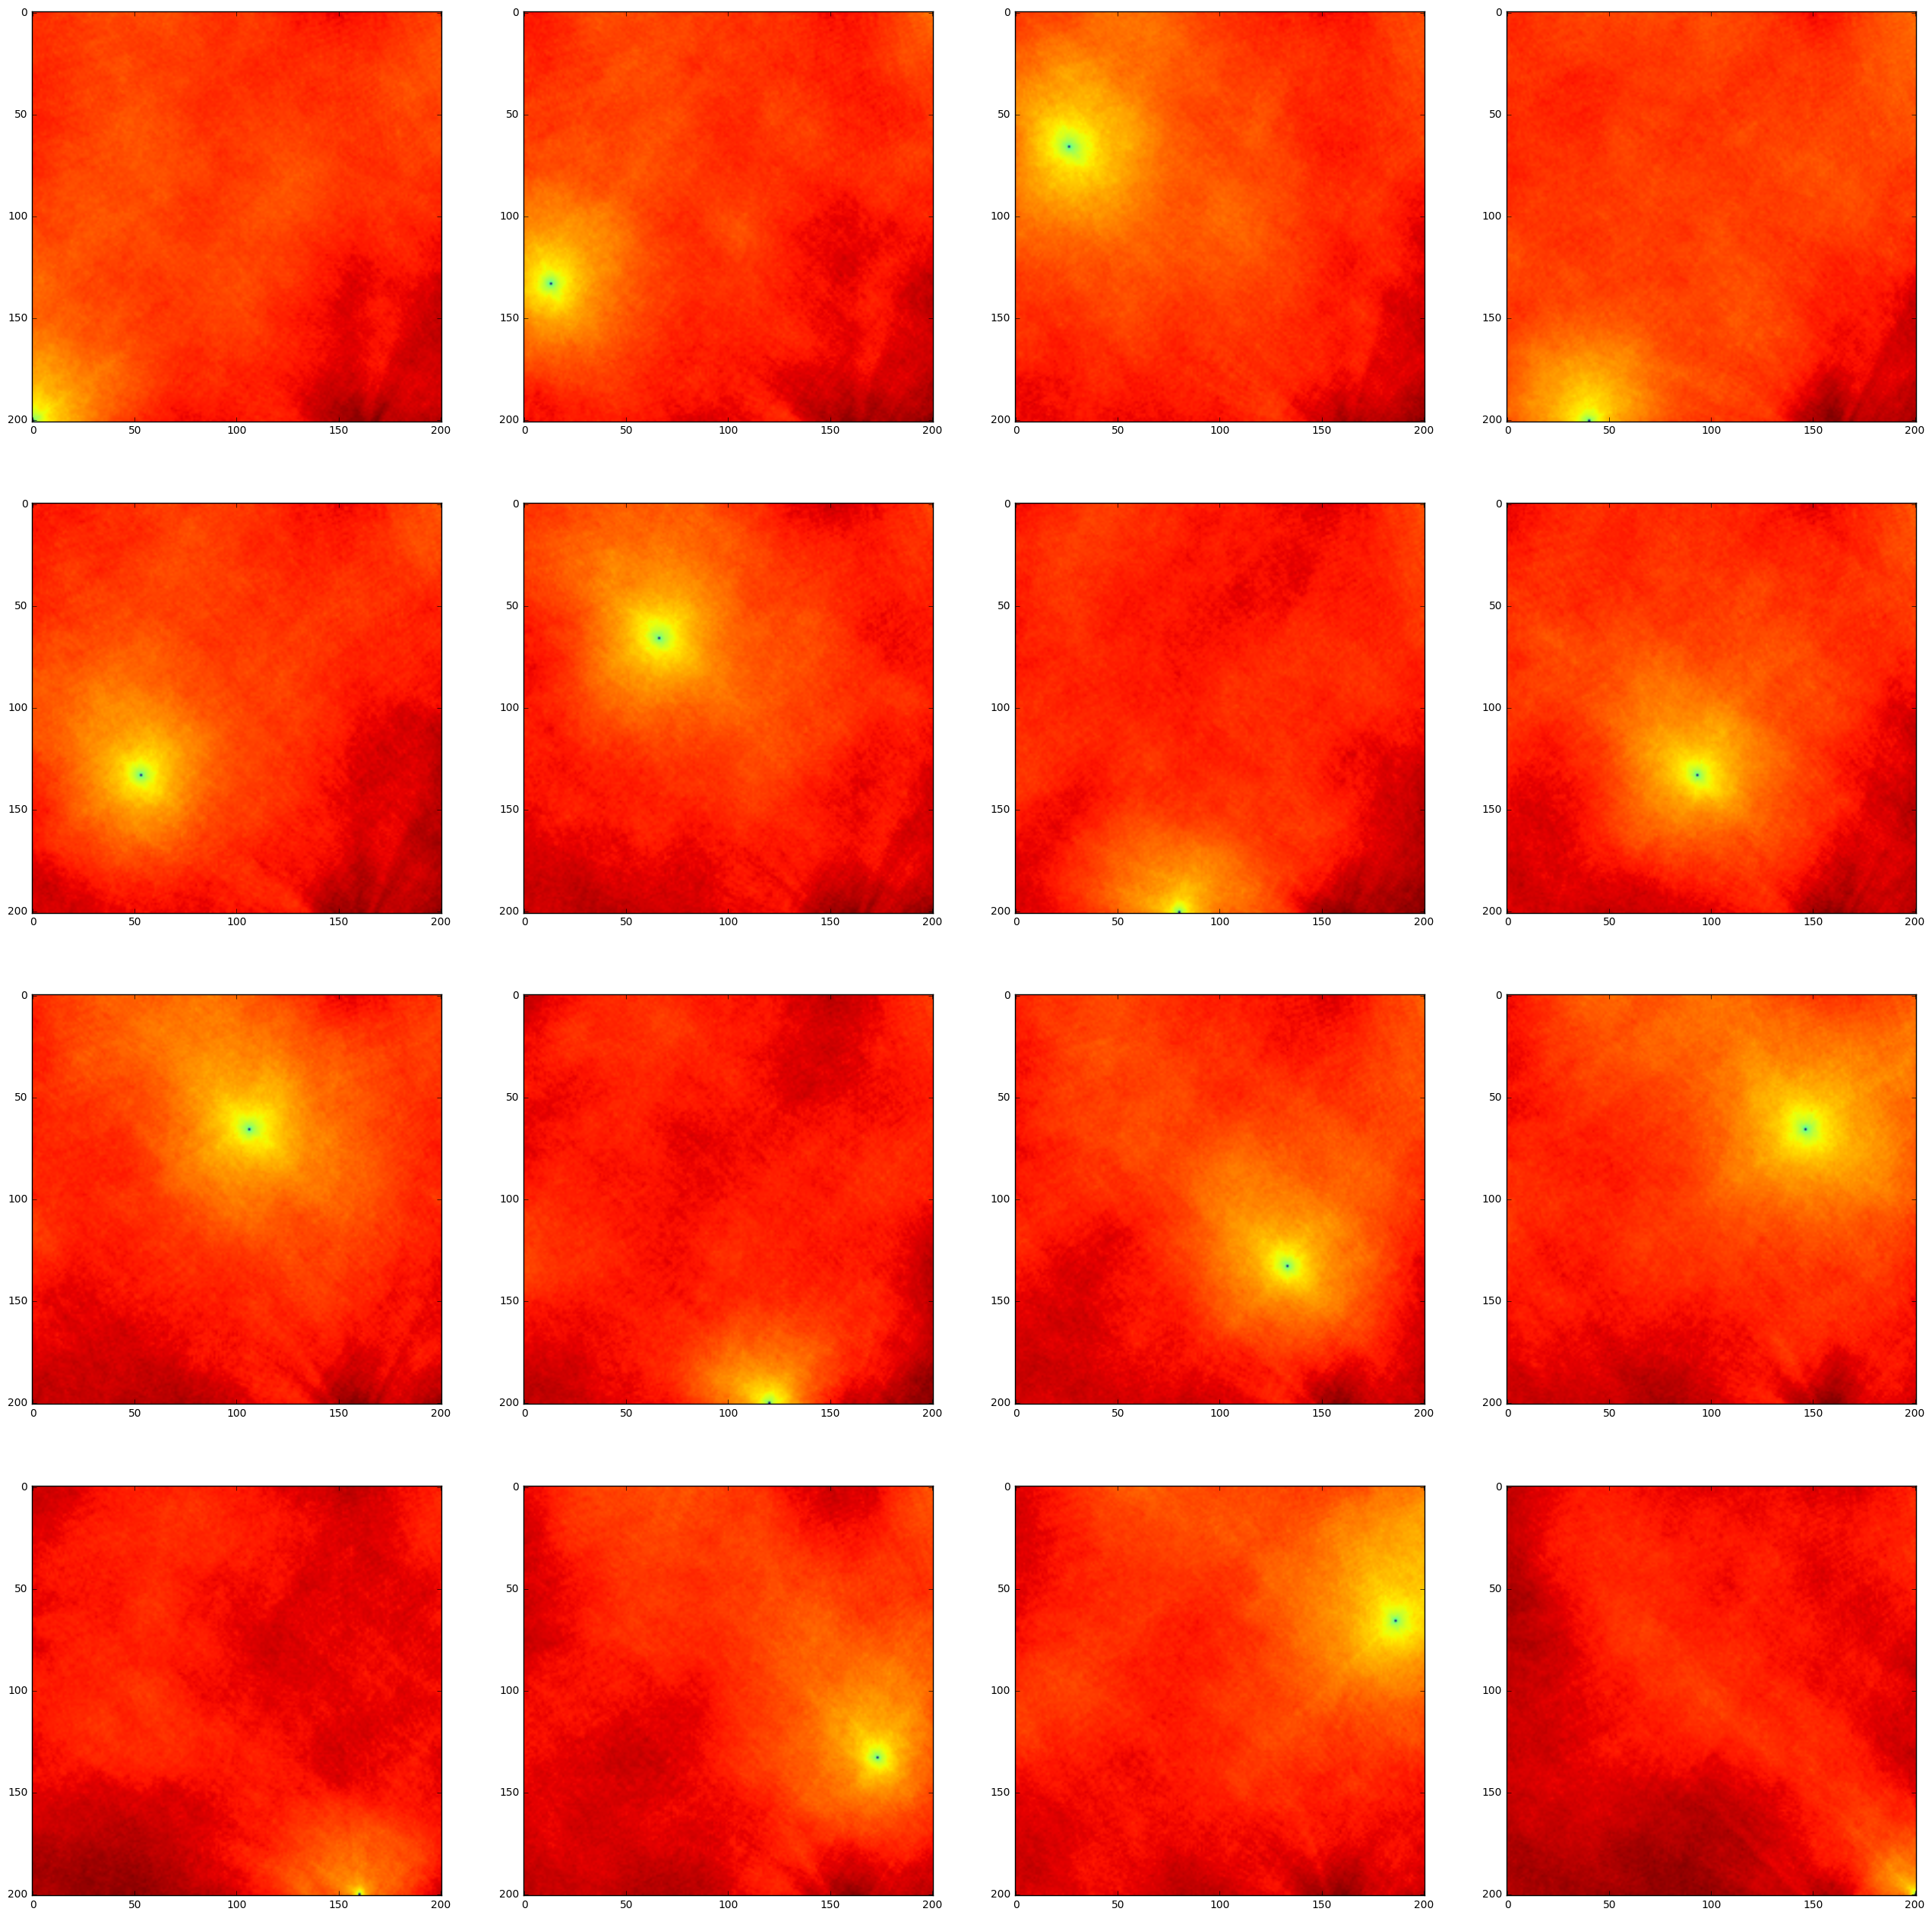

In [76]:
Z3 = np.zeros([n, len(ant_set)])
scale = 1.0
M_rescaled = resized_image_matrix(ant_set, scale)
M_rescaled.shape

for i, idx in enumerate(idxs):
    Z3[i] = manual_distance(M_rescaled[:,idx], M_rescaled)

figsize = (32,32)
nrows = 4
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for r in range(nrows):
    for c in range(ncols):
        M = np.rot90(Z3[(r*ncols+c),:].reshape(ims_per_row, ims_per_row))
        axes[r][c].imshow(M, vmin=abs(M).min(), vmax=abs(M).max())

In [62]:
def gradient_descent(M, step_size=0.5, n_steps=200):

    xs = np.arange(0, M.shape[1])  # cols
    ys = np.arange(0, M.shape[0])  # rows
    
    spl = sp.interpolate.RectBivariateSpline(xs, ys, M.T)  # Transpose this to put in x,y not row, col
    
    XS, YS = np.meshgrid(xs, ys)
    x = XS.astype(np.float64).reshape(-1)
    y = YS.astype(np.float64).reshape(-1)

    for i in range(n_steps):
        dx = spl(x=x, y=y, dx=1, grid=False)
        dy = spl(x=x, y=y, dy=1, grid=False)
        
        v = np.array([dx, dy])
        v_norm = v / np.linalg.norm(v, axis=0)

        x -= step_size * v_norm[0,:]
        np.clip(x, 0, M.shape[1]-1, out=x)

        y -= step_size * v_norm[1,:]
        np.clip(y, 0, M.shape[0]-1, out=y)
        
    return (x, y)

In [63]:
def get_catchment(I, pos_x, pos_y, threshold=2):
    x, y = gradient_descent(I, step_size=2, n_steps=1000)
    
    I2 = I.copy()
    
    distances = sp.spatial.distance.cdist(np.array([pos_x, pos_y]).reshape(1, 2),
                                      np.vstack([x, y]).T,
                                      'euclidean')
    
    indices = (distances <= threshold).astype('uint8') * 255
    catchment = indices.reshape(201,201)

    _, contours, _ = cv2.findContours(catchment, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Sort by length of contours
    # TODO: USE HIERARCHY TO INCLUDE CONTOURS WITHIN THIS AREA
    contours = sorted(contours, key=lambda lst: len(lst), reverse=True)
    cv2.drawContours(I2, contours, 0, (0,0,0), 1)
    
    return I2
    

In [60]:
def analyse(Z, idx, threshold=3, n_steps=500, filename=None):
    w_Z = np.sqrt(Z.shape[0])
    
    # The gradient
    M_landscape = Z.copy().reshape(w_Z, w_Z)
    
    # Do a gradient descent
    x, y = gradient_descent(M_landscape, step_size=2, n_steps=n_steps)
    row, col = np.unravel_index(idx, (w_Z, w_Z))
    
    # Find catchment area
    distances = sp.spatial.distance.cdist(np.array([row, col]).reshape(1,2),
                                          np.vstack([y, x]).T,
                                          'euclidean')
    
    indices = distances <= threshold
    M_catchment = indices.reshape(w_Z, w_Z)

    # Plot catchment on the landscape
    # TODO: USE HIERARCHY TO INCLUDE CONTOURS WITHIN THIS AREA
    M_landscape_contour = (M_landscape / np.max(M_landscape) * 255).astype('uint8')

    _, contours, _ = cv2.findContours(M_catchment.astype('uint8')*255,
                                      cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)
    # Sort by length of contours
    contours = sorted(contours, key=lambda lst: len(lst), reverse=True)
    cv2.drawContours(image=M_landscape_contour,
                     contours=contours,
                     contourIdx=0,
                     color=(1,0,0),  # WHY IS THIS NOT WORKING?
                     thickness=1)

    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    ax[0][0].imshow(M_landscape, interpolation='None', extent=[-5,5,5,-5])
    ax[0][1].imshow(M_landscape, interpolation='None', extent=[-5,5,5,-5])
    ax[0][1].scatter(x/20-5, y/20-5, marker='.')
    ax[0][1].set_xlim([-5, 5])
    ax[0][1].set_ylim([5, -5])
    ax[1][0].imshow(M_landscape_contour, interpolation='None', extent=[-5,5,5,-5])
    ax[1][1].imshow(distances.reshape([w_Z,w_Z]), interpolation='None', extent=[-5,5,5,-5])
    
    for i in range(2):
        for j in range(2):
            ax[i][j].set_xlabel('metres')
            ax[i][j].set_ylabel('metres')
            
    print np.sum(indices), np.sum(indices)/w_Z**2  # Print out the proportion of area where return is possible
    
    if filename:
        fig.savefig(filename)

    #return fig

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


3296 0.081582139056


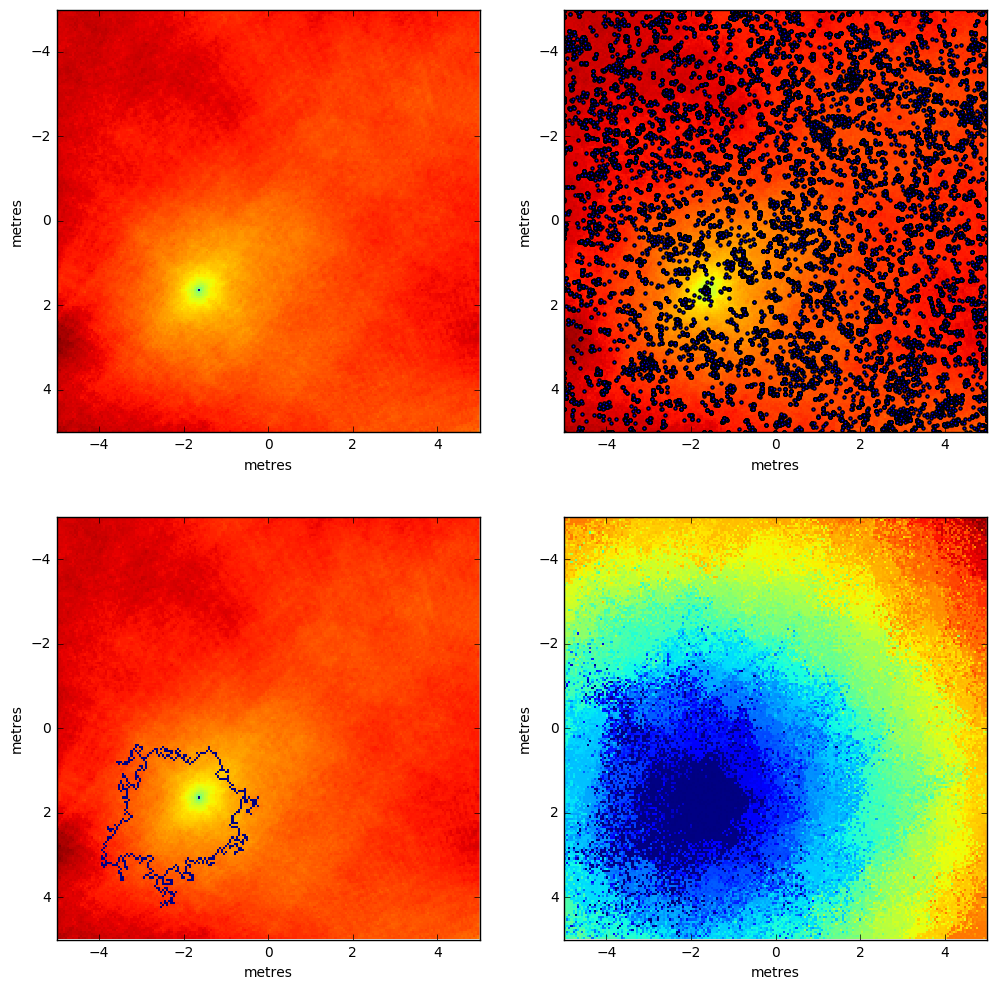

In [77]:
im_to_test = 10
analyse(Z3[im_to_test],
        idxs[im_to_test],
        threshold=10,
        n_steps=200,
        filename='pixaligned.pdf')